In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from os import listdir
from IPython.display import Markdown, display

In [6]:
kmi = pd.read_csv('Karachi Meezan 30 Historical Data.csv')

kmi.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 26, 2018","70,905.41","70,739.95","70,974.28","69,962.84",69.75K,2.35%
1,"Jul 24, 2018","69,278.08","67,506.27","69,514.85","67,426.78",60.22K,2.77%
2,"Jul 23, 2018","67,407.85","68,903.58","68,903.78","67,250.30",36.16K,-2.15%
3,"Jul 20, 2018","68,889.46","69,952.78","69,952.78","68,726.91",68.66K,-1.42%
4,"Jul 19, 2018","69,885.32","68,661.73","70,047.15","68,661.73",94.85K,2.68%


In [7]:
bonds = pd.read_csv('Pakistan 10-Year Bond Yield Historical Data.csv')

bonds.head()

,Date,Price,Open,High,Low,Change %
0,"Jun 26, 2018",8.949,8.949,8.949,8.949,-0.01%
1,"Jun 25, 2018",8.950,8.499,8.950,8.499,0.00%
2,"Jun 22, 2018",8.950,8.500,8.950,8.500,5.29%
3,"Jun 21, 2018",8.500,8.500,8.500,8.500,-0.01%
4,"Jun 20, 2018",8.501,8.501,8.501,8.501,0.01%


<h3>Pakistan Internation Bonds</h3>

In [8]:
bonds['DailyOpen'] = (bonds['Open']/100)/365
bonds['BondsLogReturn'] = np.log(bonds['DailyOpen']).diff() 
bonds = bonds.drop(0, axis=0)

In [9]:
bonds.head(3)

,Date,Price,Open,High,Low,Change %,DailyOpen,BondsLogReturn
1,"Jun 25, 2018",8.95,8.499,8.95,8.499,0.00%,0.000233,-0.051593
2,"Jun 22, 2018",8.95,8.500,8.95,8.500,5.29%,0.000233,0.000118
3,"Jun 21, 2018",8.50,8.500,8.50,8.500,-0.01%,0.000233,0.000000


<h3>KMI</h3>

In [10]:
kmi['Open'] = kmi['Open'].map(lambda x: x.replace(",", ""))
kmi['KmiLogReturn'] = np.log(kmi['Open'].astype(float)).diff()
kmi = kmi.drop(0)

In [11]:
kmi.head(3)

,Date,Price,Open,High,Low,Vol.,Change %,KmiLogReturn
1,"Jul 24, 2018","69,278.08",67506.27,"69,514.85","67,426.78",60.22K,2.77%,-0.046790
2,"Jul 23, 2018","67,407.85",68903.58,"68,903.78","67,250.30",36.16K,-2.15%,0.020488
3,"Jul 20, 2018","68,889.46",69952.78,"69,952.78","68,726.91",68.66K,-1.42%,0.015112


<h5>Merging both Data Frames</h5>

In [12]:
regression = pd.merge(kmi, bonds, how="inner", on="Date")[["Date", "KmiLogReturn", "BondsLogReturn"]]

In [13]:
regression.head()

,Date,KmiLogReturn,BondsLogReturn
0,"Jun 25, 2018",0.023515,-0.051593
1,"Jun 22, 2018",0.020488,0.000118
2,"Jun 21, 2018",0.009402,0.000000
3,"Jun 20, 2018",0.015839,0.000118
4,"Jun 19, 2018",0.001142,-0.000118


<h3>Market Risk Premium</h3>

In [14]:
regression['MRP'] = regression['KmiLogReturn'] - regression['BondsLogReturn']

In [15]:
regression.head()

,Date,KmiLogReturn,BondsLogReturn,MRP
0,"Jun 25, 2018",0.023515,-0.051593,0.075109
1,"Jun 22, 2018",0.020488,0.000118,0.020370
2,"Jun 21, 2018",0.009402,0.000000,0.009402
3,"Jun 20, 2018",0.015839,0.000118,0.015722
4,"Jun 19, 2018",0.001142,-0.000118,0.001260


In [16]:
stocks = listdir("capm")
models = {}

In [17]:
for stock in stocks:
    name = stock.split(" ")[0]
    display(Markdown("<br /> <h3>" + name + "</h3>"))
    
    e = pd.read_csv('capm/'+stock)
    e['Open'] = e['Open'].map(lambda x: str(x).replace(",", ""))
    e["StockLogReturns"] = np.log(e['Open'].astype("float")).diff()
    
    e = pd.merge(regression, e, how="inner", on="Date")[["Date", "MRP", "StockLogReturns", "BondsLogReturn"]]
    e['StockExcessReturns'] = e['StockLogReturns'] - e['BondsLogReturn']
    
    print(e.head())
    print("\n")
    
    model = sm.OLS(e['StockExcessReturns'], sm.tools.add_constant(e['MRP'])).fit()
    
    models.update({name:[model, np.average(e['StockLogReturns'])]})
    
    print(model.summary())

<br /> <h3>PIBT</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.042635       -0.051593            0.094229
1  Jun 22, 2018  0.020370         0.054982        0.000118            0.054864
2  Jun 21, 2018  0.009402        -0.099434        0.000000           -0.099434
3  Jun 20, 2018  0.015722         0.013544        0.000118            0.013427
4  Jun 19, 2018  0.001260         0.004474       -0.000118            0.004592


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     2.909
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.107
Time:                        12:22:41   Log-Likelihood:                 32.429
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>DAWH</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.052876       -0.051593            0.104469
1  Jun 22, 2018  0.020370         0.003428        0.000118            0.003310
2  Jun 21, 2018  0.009402         0.001880        0.000000            0.001880
3  Jun 20, 2018  0.015722         0.005959        0.000118            0.005841
4  Jun 19, 2018  0.001260         0.011645       -0.000118            0.011762


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     31.55
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           3.85e-05
Time:                        12:22:42   Log-Likelihood:                 50.243
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>TRGP</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.040392       -0.051593            0.091985
1  Jun 22, 2018  0.020370         0.053614        0.000118            0.053497
2  Jun 21, 2018  0.009402        -0.014791        0.000000           -0.014791
3  Jun 20, 2018  0.015722         0.032576        0.000118            0.032459
4  Jun 19, 2018  0.001260        -0.058064       -0.000118           -0.057946


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     17.97
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           0.000626
Time:                        12:22:42   Log-Likelihood:                 38.046
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>SUIS</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.050836       -0.051593            0.102429
1  Jun 22, 2018  0.020370        -0.000290        0.000118           -0.000408
2  Jun 21, 2018  0.009402         0.010384        0.000000            0.010384
3  Jun 20, 2018  0.015722         0.013962        0.000118            0.013845
4  Jun 19, 2018  0.001260         0.002826       -0.000118            0.002943


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     38.46
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.27e-05
Time:                        12:22:42   Log-Likelihood:                 47.444
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>SEAR</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.019389       -0.051593            0.070982
1  Jun 22, 2018  0.020370         0.010287        0.000118            0.010169
2  Jun 21, 2018  0.009402         0.000000        0.000000            0.000000
3  Jun 20, 2018  0.015722         0.019975        0.000118            0.019857
4  Jun 19, 2018  0.001260        -0.040655       -0.000118           -0.040537


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     11.78
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00342
Time:                        12:22:42   Log-Likelihood:                 40.700
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>FAUC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.052076       -0.051593            0.103670
1  Jun 22, 2018  0.020370         0.047831        0.000118            0.047714
2  Jun 21, 2018  0.009402        -0.019369        0.000000           -0.019369
3  Jun 20, 2018  0.015722         0.030978        0.000118            0.030860
4  Jun 19, 2018  0.001260        -0.011192       -0.000118           -0.011074


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     69.99
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           3.09e-07
Time:                        12:22:42   Log-Likelihood:                 51.704
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>NATR</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109        -0.023142       -0.051593            0.028451
1  Jun 22, 2018  0.020370        -0.007345        0.000118           -0.007462
2  Jun 21, 2018  0.009402         0.007345        0.000000            0.007345
3  Jun 20, 2018  0.015722        -0.016608        0.000118           -0.016725
4  Jun 19, 2018  0.001260        -0.004796       -0.000118           -0.004679


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     4.035
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0617
Time:                        12:22:42   Log-Likelihood:                 41.002
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>TRET</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.024664       -0.051593            0.076258
1  Jun 22, 2018  0.020370        -0.002837        0.000118           -0.002955
2  Jun 21, 2018  0.009402         0.022751        0.000000            0.022751
3  Jun 20, 2018  0.015722         0.024415        0.000118            0.024297
4  Jun 19, 2018  0.001260        -0.008163       -0.000118           -0.008046


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     32.41
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           3.33e-05
Time:                        12:22:42   Log-Likelihood:                 51.226
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>KAPCO</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.000173       -0.051593            0.051766
1  Jun 22, 2018  0.020370         0.014389        0.000118            0.014271
2  Jun 21, 2018  0.009402        -0.017153        0.000000           -0.017153
3  Jun 20, 2018  0.015722         0.007240        0.000118            0.007123
4  Jun 19, 2018  0.001260         0.010763       -0.000118            0.010881


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     21.30
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           0.000286
Time:                        12:22:42   Log-Likelihood:                 55.374
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>HASC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.035718       -0.051593            0.087311
1  Jun 22, 2018  0.020370         0.034859        0.000118            0.034741
2  Jun 21, 2018  0.009402         0.023112        0.000000            0.023112
3  Jun 20, 2018  0.015722         0.045219        0.000118            0.045101
4  Jun 19, 2018  0.001260         0.006341       -0.000118            0.006459




/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     34.83
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           2.23e-05
Time:                        12:22:42   Log-Likelihood:                 46.159
No. Observations:                  18   AIC:                            -88.32
Df Residuals:                      16   BIC:                            -86.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.005      0.414      0.6

<br /> <h3>OGDC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.014812       -0.051593            0.066406
1  Jun 22, 2018  0.020370         0.011958        0.000118            0.011840
2  Jun 21, 2018  0.009402         0.015477        0.000000            0.015477
3  Jun 20, 2018  0.015722         0.013471        0.000118            0.013353
4  Jun 19, 2018  0.001260         0.011481       -0.000118            0.011599


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     40.64
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           9.20e-06
Time:                        12:22:42   Log-Likelihood:                 56.808
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>MILM</h3>

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.008734       -0.051593            0.060327
1  Jun 22, 2018  0.020370        -0.011369        0.000118           -0.011486
2  Jun 21, 2018  0.009402         0.054012        0.000000            0.054012
3  Jun 20, 2018  0.015722         0.017265        0.000118            0.017148
4  Jun 19, 2018  0.001260         0.008157       -0.000118            0.008274


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     15.30
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00124
Time:                        12:22:42   Log-Likelihood:                 51.193
No. Observations:                  18   AIC:      

<br /> <h3>ATOC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.006403       -0.051593            0.057997
1  Jun 22, 2018  0.020370         0.014085        0.000118            0.013967
2  Jun 21, 2018  0.009402         0.020762        0.000000            0.020762
3  Jun 20, 2018  0.015722         0.059109        0.000118            0.058991
4  Jun 19, 2018  0.001260        -0.012277       -0.000118           -0.012160




/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     10.26
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00553
Time:                        12:22:43   Log-Likelihood:                 47.189
No. Observations:                  18   AIC:                            -90.38
Df Residuals:                      16   BIC:                            -88.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.005      2.006      0.0

<br /> <h3>APL</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.030086       -0.051593            0.081680
1  Jun 22, 2018  0.020370         0.004922        0.000118            0.004804
2  Jun 21, 2018  0.009402        -0.003279        0.000000           -0.003279
3  Jun 20, 2018  0.015722         0.017740        0.000118            0.017622
4  Jun 19, 2018  0.001260        -0.014248       -0.000118           -0.014131


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     37.58
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.45e-05
Time:                        12:22:43   Log-Likelihood:                 55.291
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>SHEL</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.009539       -0.051593            0.061132
1  Jun 22, 2018  0.020370         0.049242        0.000118            0.049124
2  Jun 21, 2018  0.009402         0.012097        0.000000            0.012097
3  Jun 20, 2018  0.015722         0.011864        0.000118            0.011747
4  Jun 19, 2018  0.001260         0.014599       -0.000118            0.014716


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     15.15
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00130
Time:                        12:22:43   Log-Likelihood:                 47.234
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>SUIN</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.084121       -0.051593            0.135714
1  Jun 22, 2018  0.020370        -0.038499        0.000118           -0.038616
2  Jun 21, 2018  0.009402         0.028742        0.000000            0.028742
3  Jun 20, 2018  0.015722         0.033738        0.000118            0.033620
4  Jun 19, 2018  0.001260         0.009434       -0.000118            0.009552


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     29.05
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           6.02e-05
Time:                        12:22:43   Log-Likelihood:                 40.031
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>AKDC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 22, 2018  0.020370        -0.051129        0.000118           -0.051247
1  Jun 20, 2018  0.015722         0.051209        0.000118            0.051091
2  Jun 13, 2018 -0.007289        -0.001361        0.000000           -0.001361
3  Jun 12, 2018  0.015164         0.000000        0.000000            0.000000
4  Jun 11, 2018  0.006764         0.000000        0.000000            0.000000


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.036
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.356
Time:                        12:22:43   Log-Likelihood:                 14.532
No. Observations:                   7   AIC:      

/usr/local/lib/python2.7/dist-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<br /> <h3>MARI</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.000000       -0.051593            0.051593
1  Jun 22, 2018  0.020370         0.051793        0.000118            0.051676
2  Jun 21, 2018  0.009402         0.048766        0.000000            0.048766
3  Jun 14, 2018 -0.005394        -0.000476        0.000000           -0.000476
4  Jun 11, 2018  0.006764         0.011834        0.000000            0.011834




/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.6450
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.445
Time:                        12:22:43   Log-Likelihood:                 14.847
No. Observations:                  10   AIC:                            -25.69
Df Residuals:                       8   BIC:                            -25.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.020      0.280      0.7

<br /> <h3>KELE</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.009390       -0.051593            0.060983
1  Jun 22, 2018  0.020370         0.027652        0.000118            0.027534
2  Jun 21, 2018  0.009402         0.026907        0.000000            0.026907
3  Jun 20, 2018  0.015722        -0.008889        0.000118           -0.009007
4  Jun 19, 2018  0.001260         0.008889       -0.000118            0.009007


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     19.85
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           0.000399
Time:                        12:22:43   Log-Likelihood:                 53.064
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>MPLF</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.051427       -0.051593            0.103020
1  Jun 22, 2018  0.020370         0.058339        0.000118            0.058221
2  Jun 21, 2018  0.009402         0.030264        0.000000            0.030264
3  Jun 20, 2018  0.015722         0.048433        0.000118            0.048315
4  Jun 19, 2018  0.001260         0.010152       -0.000118            0.010270


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     38.68
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.23e-05
Time:                        12:22:43   Log-Likelihood:                 46.131
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>ATOR</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.025740       -0.051593            0.077334
1  Jun 22, 2018  0.020370         0.007034        0.000118            0.006916
2  Jun 21, 2018  0.009402         0.013921        0.000000            0.013921
3  Jun 20, 2018  0.015722         0.042892        0.000118            0.042774
4  Jun 19, 2018  0.001260        -0.006689       -0.000118           -0.006571


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     13.12
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00229
Time:                        12:22:43   Log-Likelihood:                 37.644
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>NISM</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.022828       -0.051593            0.074421
1  Jun 22, 2018  0.020370         0.020619        0.000118            0.020502
2  Jun 21, 2018  0.009402        -0.019856        0.000000           -0.019856
3  Jun 20, 2018  0.015722         0.053304        0.000118            0.053186
4  Jun 19, 2018  0.001260         0.006623       -0.000118            0.006740


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     12.48
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00277
Time:                        12:22:44   Log-Likelihood:                 40.210
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>DGKH</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.013754       -0.051593            0.065347
1  Jun 22, 2018  0.020370         0.043671        0.000118            0.043554
2  Jun 21, 2018  0.009402         0.008425        0.000000            0.008425
3  Jun 20, 2018  0.015722         0.026922        0.000118            0.026805
4  Jun 19, 2018  0.001260        -0.000165       -0.000118           -0.000047


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     22.28
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           0.000231
Time:                        12:22:44   Log-Likelihood:                 46.093
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>PACK</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109        -0.021053       -0.051593            0.030540
1  Jun 22, 2018  0.020370         0.000000        0.000118           -0.000118
2  Jun 21, 2018  0.009402         0.053843        0.000000            0.053843
3  Jun 20, 2018  0.015722         0.005830        0.000118            0.005712
4  Jun 19, 2018  0.001260        -0.001504       -0.000118           -0.001387


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.984
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.178
Time:                        12:22:44   Log-Likelihood:                 41.356
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>LUKC</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.051273       -0.051593            0.102867
1  Jun 22, 2018  0.020370         0.017860        0.000118            0.017742
2  Jun 21, 2018  0.009402         0.005896        0.000000            0.005896
3  Jun 20, 2018  0.015722         0.047635        0.000118            0.047518
4  Jun 19, 2018  0.001260         0.014788       -0.000118            0.014906


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     59.79
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           8.60e-07
Time:                        12:22:44   Log-Likelihood:                 51.704
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>EGCH</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.001946       -0.051593            0.053539
1  Jun 22, 2018  0.020370         0.020527        0.000118            0.020409
2  Jun 21, 2018  0.009402        -0.003180        0.000000           -0.003180
3  Jun 20, 2018  0.015722         0.019240        0.000118            0.019123
4  Jun 19, 2018  0.001260         0.004364       -0.000118            0.004482


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     34.81
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           2.24e-05
Time:                        12:22:44   Log-Likelihood:                 55.034
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>MARI</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.000000       -0.051593            0.051593
1  Jun 22, 2018  0.020370         0.051793        0.000118            0.051676
2  Jun 21, 2018  0.009402         0.048766        0.000000            0.048766
3  Jun 14, 2018 -0.005394        -0.000476        0.000000           -0.000476
4  Jun 11, 2018  0.006764         0.011834        0.000000            0.011834


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.6450
Date:                Tue, 14 Aug 2018   Prob (F-statistic):              0.445
Time:                        12:22:44   Log-Likelihood:                 14.847
No. Observations:                  10   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<br /> <h3>PKEL</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.038765       -0.051593            0.090358
1  Jun 22, 2018  0.020370         0.048804        0.000118            0.048686
2  Jun 21, 2018  0.009402        -0.014308        0.000000           -0.014308
3  Jun 20, 2018  0.015722         0.057912        0.000118            0.057794
4  Jun 19, 2018  0.001260        -0.022928       -0.000118           -0.022810


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     20.19
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           0.000368
Time:                        12:22:44   Log-Likelihood:                 38.677
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>PPL</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.002846       -0.051593            0.054440
1  Jun 22, 2018  0.020370         0.027796        0.000118            0.027678
2  Jun 21, 2018  0.009402         0.022640        0.000000            0.022640
3  Jun 20, 2018  0.015722         0.000045        0.000118           -0.000073
4  Jun 19, 2018  0.001260        -0.004650       -0.000118           -0.004532


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     36.10
Date:                Tue, 14 Aug 2018   Prob (F-statistic):           1.82e-05
Time:                        12:22:44   Log-Likelihood:                 58.510
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>GLAO</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.022044       -0.051593            0.073638
1  Jun 22, 2018  0.020370         0.020992        0.000118            0.020874
2  Jun 21, 2018  0.009402        -0.002403        0.000000           -0.002403
3  Jun 20, 2018  0.015722         0.051166        0.000118            0.051048
4  Jun 19, 2018  0.001260        -0.033189       -0.000118           -0.033072


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     5.494
Date:                Tue, 14 Aug 2018   Prob (F-statistic):             0.0323
Time:                        12:22:44   Log-Likelihood:                 35.375
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<br /> <h3>EPCL</h3>

           Date       MRP  StockLogReturns  BondsLogReturn  StockExcessReturns
0  Jun 25, 2018  0.075109         0.022728       -0.051593            0.074322
1  Jun 22, 2018  0.020370         0.089016        0.000118            0.088898
2  Jun 21, 2018  0.009402        -0.010332        0.000000           -0.010332
3  Jun 20, 2018  0.015722         0.047518        0.000118            0.047400
4  Jun 19, 2018  0.001260        -0.016836       -0.000118           -0.016718


                            OLS Regression Results                            
Dep. Variable:     StockExcessReturns   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     12.15
Date:                Tue, 14 Aug 2018   Prob (F-statistic):            0.00305
Time:                        12:22:44   Log-Likelihood:                 38.466
No. Observations:                  18   AIC:      

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [18]:
count = 0
for model in models:
    if models[model][0].tvalues.const < 2:
        count += 1
print(str(count) + "/" + str(len(models.keys())))

28/30


<h3>Number of Aphas < 2:&nbsp;&nbsp; 28 out of 30</h3>

In [19]:
beta = []
returns = []

for model in models:
    beta.append(models[model][0].params[1])
    returns.append(models[model][1])

In [20]:
df = pd.DataFrame(np.transpose([models.keys(), beta, returns]), columns=["Stock", "Beta", "Returns"])
df

,Stock,Beta,Returns
0,LUKC,1.346465184480641,0.006608441270075834
1,FAUC,1.4568608875583218,0.007013714456105201
2,ATOR,1.3774366062853622,-0.00508081963010534
3,SEAR,1.1013719338647743,-0.00579761129336588
4,SHEL,0.8687529898163716,0.003233812522109611
5,HASC,1.3984037627561894,0.005423419783424717
6,EPCL,1.2666536847533003,0.0003092997818684316
7,AKDC,-1.1600522884977005,0.007535478823893525
8,PKEL,1.613638209439337,0.0011865225982329432
9,GLAO,1.0111566558310694,-0.003480262953179874


In [21]:
reg = sm.OLS(np.asarray( df['Returns'].astype("float") ), sm.add_constant( np.asarray( df['Beta'].astype("float") ) )).fit()
reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     -0.033    
Dependent Variable: y                AIC:                -215.1222 
Date:               2018-08-14 12:22 BIC:                -212.3198 
No. Observations:   30               Log-Likelihood:     109.56    
Df Model:           1                F-statistic:        0.06439   
Df Residuals:       28               Prob (F-statistic): 0.802     
R-squared:          0.002            Scale:              4.2206e-05
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const     0.0028      0.0025     1.1251    0.2701    -0.0023    0.0080
x1       -0.0006      0.0023    -0.2538    0.8015    -0.0052    0.0041
-------------------------------------------------------------------
Omnibus:               3.768         Durbin-Watson:           2.277
Prob(Omnibus):         0.152         Jarque-Bera (JB):        2.785
Skew:                  -0.170        Prob(JB):                0.249
Kurtosis:              4.453         Condition No.:           4    
===================================================================

"""

([<matplotlib.axis.YTick at 0x7f9f25d8ca90>,
 <a list of 3 Text yticklabel objects>)

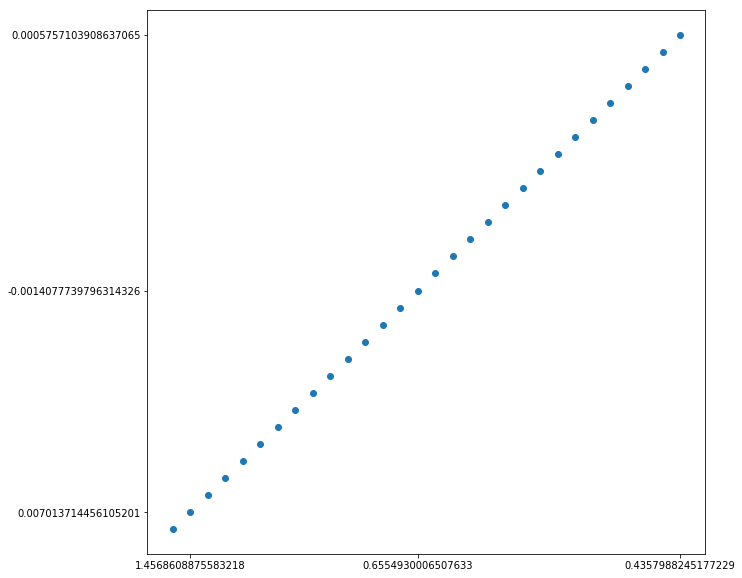

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df['Beta'], df['Returns'])

plt.xticks([1, (len(df)-1)/2, len(df)-1])
plt.yticks([1, (len(df)-1)/2, len(df)-1])

#ax.plot(df['Returns'].astype("float"), df['Returns'].astype("float")*reg.params[0] + reg.params[1])



<h3>More than 90% of the Alphas are zero. According to the scatter plot the Betas are linearly correlated with the average returns. Evidence suggestes that the CAPM holds.</h3>